<a href="https://colab.research.google.com/github/AndrewRomitti/TorchFusionGAN_Dementia/blob/main/torchfusionGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Utilizing the TorchFusion Library in creating Conditional GANS for Synthetic MRI Images at varying degrees of Dementia

In [ ]:
!pip install -q torchfusion

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.1/67.1 kB 1.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.6/101.6 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 23.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
from google.colab import drive

drive.mount(r'/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"andrewromitti1","key":"afba0c1d61c28adb86401ceb91bee3ad"}'}

In [ ]:
!pip install -q kaggle

In [ ]:

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d tourist55/alzheimers-dataset-4-class-of-images

 38% 13.0M/34.1M [00:00<00:00, 129MB/s]
100% 34.1M/34.1M [00:00<00:00, 185MB/s]


In [ ]:
!unzip -q /content/alzheimers-dataset-4-class-of-images.zip
print("unzipped")

unzipped


In [ ]:
import os
import shutil
import glob

test_path = r"/content/Alzheimer_s Dataset/test"

train_path = r"/content/Alzheimer_s Dataset/train"

for dir in os.listdir(test_path):
  for img_path in glob.glob(test_path+"/"+dir+"/"+"*.jpg"):
    shutil.move(img_path, train_path+'/'+dir)

In [ ]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

train_data_path = r'/content/Alzheimer_s Dataset/train'

image_size = 128
batch_size = 128//2
stats = (0.5,0.5,0.5,) ,(0.5,0.5,0.5)

import os
import torch
import glob
from PIL import Image

class AugmentedAlzheimerMRIDataset(torch.utils.data.Dataset):

  def __init__(self, target_dir, transforms=None):
    self.target_dir = target_dir

    self.image_paths = []
    for dir in os.listdir(target_dir):
      for img_path in glob.glob(target_dir+"/"+dir+"/"+"*.jpg"):
        self.image_paths.append(img_path)

    self.transforms = transforms
    self.classes = sorted(os.listdir(target_dir+"/"))
    self.class_to_idx = {class_name: i for i, class_name in enumerate(self.classes)}
    self.class_count = []
    self.class_count_dict = {}

  def load_image(self, idx):
    return Image.open(self.image_paths[idx]).convert("RGB")

  def class_counts(self):
    PATH = self.target_dir

    for dir in os.listdir(PATH):
      target_dir = PATH + "/" + dir
      files = os.listdir(target_dir)
      count = len(files)
      self.class_count.append(count)

    return self.class_count

  def __len__(self):
    return len(self.image_paths)

  def __getitem__(self, index):
    img = self.load_image(index)
    class_name = os.path.dirname(self.image_paths[index]).split("/",-1)[-1]
    class_idx = self.class_to_idx[class_name]

    if self.transforms:
      return self.transforms(img), class_idx
    else:
      return img, class_idx

transforms = T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats),
])

dataset = AugmentedAlzheimerMRIDataset(train_data_path, transforms=transforms)

data_loader = torch.utils.data.DataLoader(dataset, batch_size=4, shuffle=True)

In [ ]:
#dataset = mnist_loader(size=32,batch_size=64)

In [ ]:
from torchfusion.gan.learners import *
from torchfusion.gan.applications import StandardGenerator,StandardProjectionDiscriminator
from torch.optim import Adam
from torchfusion.datasets import mnist_loader
import torch.cuda as cuda
import torch.nn as nn
import torch
from torch.distributions import Normal

G = StandardGenerator(output_size=(3,128,128),latent_size=120,num_classes=4)
D = StandardProjectionDiscriminator(input_size=(3,128,128),apply_sigmoid=False,num_classes=4)

if cuda.is_available():
    G = nn.DataParallel(G.cuda())
    D = nn.DataParallel(D.cuda())

g_optim = Adam(G.parameters(),lr=0.0002,betas=(0.5,0.999))
d_optim = Adam(D.parameters(),lr=0.0002,betas=(0.5,0.999))

dataset = data_loader

learner = RAvgStandardGanLearner(G,D)

Epoch 1 of 15


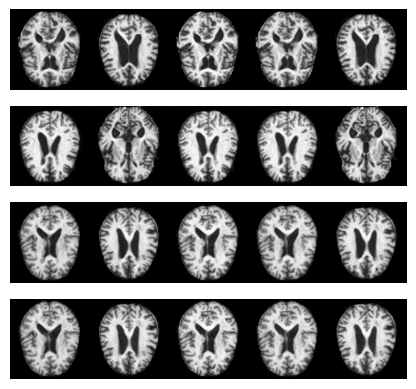

New Generator model saved at ./Alzheimer-gan/gen_models/gen_model_1.pth
New Discriminator model saved at ./Alzheimer-gan/disc_models/disc_model_1.pth
Epoch: 1, Duration: 1120.660845041275 , Gen Loss: 10.938533935546875 Disc Loss: 0.01968891143798828
Epoch 2 of 15


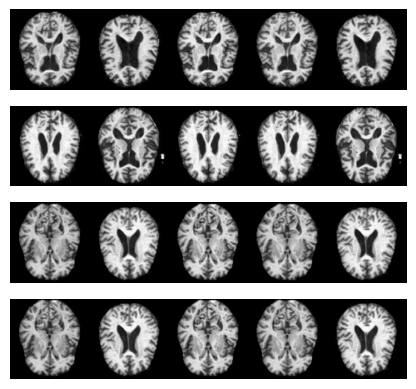

New Generator model saved at ./Alzheimer-gan/gen_models/gen_model_2.pth
New Discriminator model saved at ./Alzheimer-gan/disc_models/disc_model_2.pth
Epoch: 2, Duration: 1110.3489696979523 , Gen Loss: 10.81683349609375 Disc Loss: 0.020879435539245605
Epoch 3 of 15


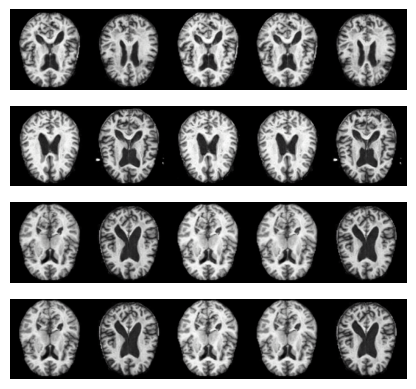

New Generator model saved at ./Alzheimer-gan/gen_models/gen_model_3.pth
New Discriminator model saved at ./Alzheimer-gan/disc_models/disc_model_3.pth
Epoch: 3, Duration: 1107.419275522232 , Gen Loss: 9.826478271484374 Disc Loss: 0.019523862600326538
Epoch 4 of 15


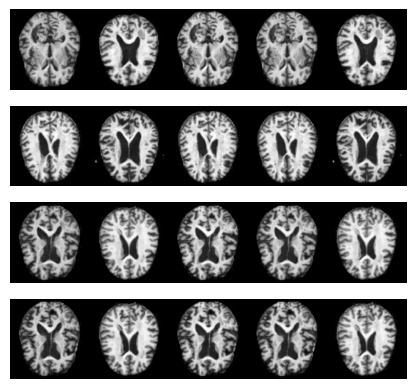

New Generator model saved at ./Alzheimer-gan/gen_models/gen_model_4.pth
New Discriminator model saved at ./Alzheimer-gan/disc_models/disc_model_4.pth
Epoch: 4, Duration: 1107.536831855774 , Gen Loss: 10.409019775390625 Disc Loss: 0.022063961029052736
Epoch 5 of 15


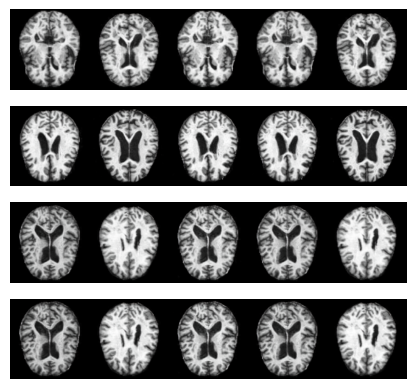

New Generator model saved at ./Alzheimer-gan/gen_models/gen_model_5.pth
New Discriminator model saved at ./Alzheimer-gan/disc_models/disc_model_5.pth
Epoch: 5, Duration: 1107.3516147136688 , Gen Loss: 10.31770263671875 Disc Loss: 0.021771507263183595
Epoch 6 of 15


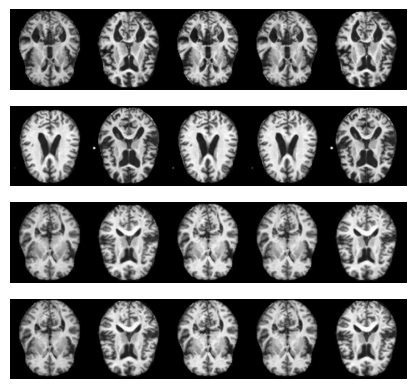

New Generator model saved at ./Alzheimer-gan/gen_models/gen_model_6.pth
New Discriminator model saved at ./Alzheimer-gan/disc_models/disc_model_6.pth
Epoch: 6, Duration: 1111.1985712051392 , Gen Loss: 9.738614501953125 Disc Loss: 0.021440412998199463
Epoch 7 of 15


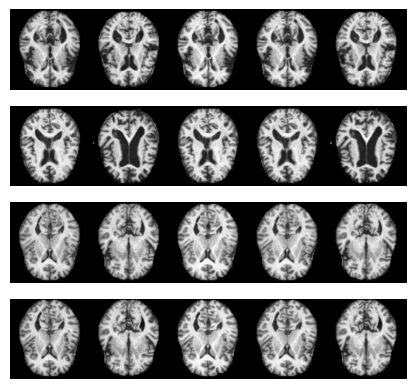

New Generator model saved at ./Alzheimer-gan/gen_models/gen_model_7.pth
New Discriminator model saved at ./Alzheimer-gan/disc_models/disc_model_7.pth
Epoch: 7, Duration: 1107.7626643180847 , Gen Loss: 11.724415283203125 Disc Loss: 0.022296180725097658
Epoch 8 of 15


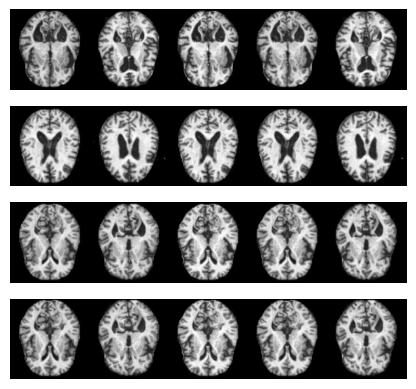

New Generator model saved at ./Alzheimer-gan/gen_models/gen_model_8.pth
New Discriminator model saved at ./Alzheimer-gan/disc_models/disc_model_8.pth
Epoch: 8, Duration: 1107.2780718803406 , Gen Loss: 12.44158935546875 Disc Loss: 0.024388506412506103
Epoch 9 of 15


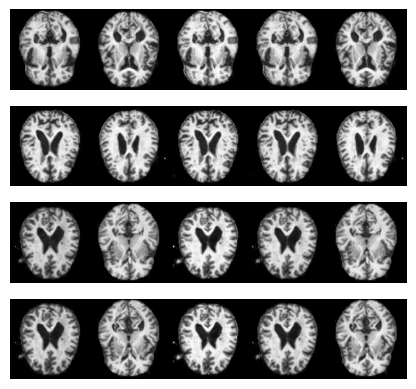

New Generator model saved at ./Alzheimer-gan/gen_models/gen_model_9.pth
New Discriminator model saved at ./Alzheimer-gan/disc_models/disc_model_9.pth
Epoch: 9, Duration: 1108.2848100662231 , Gen Loss: 11.965645751953126 Disc Loss: 0.02287558317184448
Epoch 10 of 15


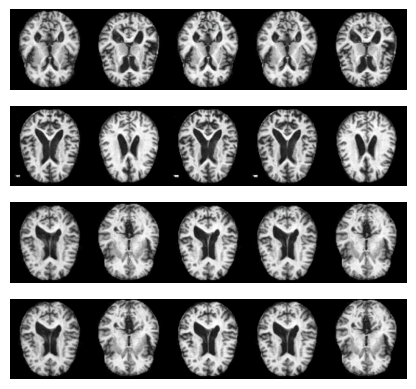

New Generator model saved at ./Alzheimer-gan/gen_models/gen_model_10.pth
New Discriminator model saved at ./Alzheimer-gan/disc_models/disc_model_10.pth
Epoch: 10, Duration: 1107.2320473194122 , Gen Loss: 9.560286865234374 Disc Loss: 0.020362141132354735
Epoch 11 of 15


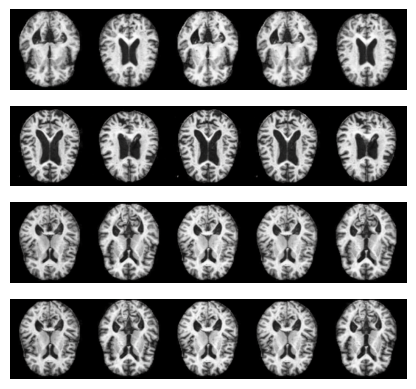

New Generator model saved at ./Alzheimer-gan/gen_models/gen_model_11.pth
New Discriminator model saved at ./Alzheimer-gan/disc_models/disc_model_11.pth
Epoch: 11, Duration: 1107.1800055503845 , Gen Loss: 11.345595703125 Disc Loss: 0.020318503379821776
Epoch 12 of 15


In [ ]:
learner.train(dataset, num_classes=4, gen_optimizer=g_optim, disc_optimizer=d_optim, save_outputs_interval=6400//4, model_dir="./Alzheimer-gan",latent_size=120, num_epochs=15, batch_log=False)

In [ ]:
shutil.move('/content/Alzheimer-gan/disc_models/disc_model_14.pth',"/content/drive/MyDrive/Alzheimer-gan/night_models/")
shutil.move('/content/Alzheimer-gan/gen_models/gen_model_14.pth',"/content/drive/MyDrive/Alzheimer-gan/night_models/")

In [ ]:
%matplotlib inline
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torch import autograd
from torch.autograd import Variable
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

from torchfusion.gan.learners import *
from torchfusion.gan.applications import StandardGenerator,StandardProjectionDiscriminator
from torch.distributions import Normal

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
device

In [ ]:
G = StandardGenerator(output_size=(3,128,128),latent_size=512,num_classes=4)

if torch.cuda.is_available():
    G = nn.DataParallel(G.cuda())

learner = RAvgHingeGanLearner(G,None)
learner.load_generator("/content/drive/MyDrive/Alzheimer-gan/gen_models/gen_model_50.pth")

classes = ["ModerateDemented","NonDemented","VeryMildDemented"]

num_images_per_class = 500

for idx, class_name in enumerate(classes):
  for i in range(num_images_per_class):
    "Define an instance of the normal distribution"
    dist = Normal(0,1)

    #Get a sample latent vector from the distribution
    latent_vector = dist.sample((1,512))

    #Define the class of the image you want to generate
    label = torch.LongTensor(1).fill_(0)

    #Run inference

    image = learner.predict([latent_vector,label])
    images = make_grid(image.cpu().data, normalize=True)
    images = np.transpose(images.numpy(), (1, 2, 0))
    plt.axis("off")
    plt.imshow(images)
    plt.savefig("/content/drive/MyDrive/MRI_Gan_Project/SyntheticDs/"+str(class_name)+"/"+str(i+33)+"_"+str(class_name)+".png",bbox_inches="tight")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')